# Aula 3: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural simples para prever a proxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Língua".

Este dataset já possui um tamanho razoável e é bem provável que você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset tem 2 milhões de tokens. Não dê comando de imprimí-lo
- durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- não deixe para fazer esse exercício na véspera. Ele é trabalhoso e precisará de um tempo maior que o exercício passado
- vamos compartilhando com os colegas sobre as dificuldades

# Download do dataset 

Iremos usar o dataset [Wikitext-2](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) para treinar e avaliar nosso modelo de linguagem.

In [3]:
!wget -nc https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -o wikitext-2-v1.zip

File ‘wikitext-2-v1.zip’ already there; not retrieving.

Archive:  wikitext-2-v1.zip
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


## Importação dos pacotes

In [4]:
import collections
import itertools
import random
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm_notebook

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


#Funções do Professor


In [0]:
def load_tokens(path):
    text = open(path).read().lower()
    # Split sem argumentos remove quebras de linha e espaços duplicados.
    return text.split()
    

def build_vocab(tokens, vocab_size):
    word_frequency = collections.Counter(tokens)

    vocab = {token: index for index, (token, _) in enumerate(
        word_frequency.most_common(vocab_size))}
  
    vocab['[PAD]'] = len(vocab)
    # Adicionamos o token "<unk>" para lidar com palavras não presentes no
    # vocabulário . O dataset text8 já contem este token, mas pode ser que ele
    # não tenha sido adicionado quando filtramos com `vocab_size`.
    if '<unk>' not in vocab:
        vocab['<unk>'] = len(vocab)
    return vocab 

def input_five_firtst_pads(token_list):
  pad_array = ['[PAD]','[PAD]','[PAD]','[PAD]','[PAD]']
  return pad_array + token_list


In [0]:
train_tokens = load_tokens('wikitext-2/wiki.train.tokens')
valid_tokens = load_tokens('wikitext-2/wiki.valid.tokens')
test_tokens = load_tokens('wikitext-2/wiki.test.tokens')


In [9]:
#reparar que para a mesma posição retorna elementos diferents em cada token
print(train_tokens[0:20])
print(valid_tokens[0:20])
print(test_tokens[0:20])

['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '=', 'valkyria', 'chronicles', 'iii', '=', 'senjō', 'no', 'valkyria', '3', ':', '<unk>', 'chronicles', '(', 'japanese', ':']
['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '=', 'homarus', 'gammarus', '=', 'homarus', 'gammarus', ',', 'known', 'as', 'the', 'european', 'lobster', 'or', 'common', 'lobster']
['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '=', 'robert', '<unk>', '=', 'robert', '<unk>', 'is', 'an', 'english', 'film', ',', 'television', 'and', 'theatre', 'actor']


In [0]:
train_tokens = train_tokens[:10000]
valid_tokens = valid_tokens[:10000]
test_tokens = test_tokens[:10000]

In [11]:
vocab_size = 10000
train_vocab = build_vocab(train_tokens, vocab_size=vocab_size)
print(f'Vocab has {len(train_vocab)} tokens')
print(f'10 sample tokens: {list(itertools.islice(train_vocab.keys(), 10))}')
print(f'10 sample tokens: {list(itertools.islice(train_vocab, 10))}')


Vocab has 2183 tokens
10 sample tokens: ['the', ',', '.', 'of', '<unk>', 'and', 'in', 'to', 'a', '=']
10 sample tokens: ['the', ',', '.', 'of', '<unk>', 'and', 'in', 'to', 'a', '=']


#Classe Dataset


In [0]:
from torch.utils.data import Dataset, DataLoader
from numpy import genfromtxt

class Wikitext2TorchPentagrams(Dataset):
  def __init__(self, path ,tokens_size,vocab_size,tokens_limit=True):
    super(Wikitext2TorchPentagrams, self).__init__()
    self.path = path
    if tokens_limit:
      self.tokens_size = tokens_size
    else:
       self.tokens_size = None
    self.vocab_size = vocab_size
    
    self.tokens_puros = self.load_tokens()
    self.vocab = self.build_vocab()
    if tokens_limit:
      self.tokens = 5 * ['[PAD]'] + self.tokens_puros[:self.tokens_size]
    else:
      self.tokens = 5 * ['[PAD]'] + self.tokens_puros
    self.context_idxs,self.target_idxs = self.return_context_target_torch()

  
  def load_tokens(self):
    text = open(self.path).read().lower()
    # Split sem argumentos remove quebras de linha e espaços duplicados.
    return text.split()
    

  def build_vocab(self):
    word_frequency = collections.Counter(self.tokens_puros)

    vocab = {token: index for index, (token, _) in enumerate(
          word_frequency.most_common(self.vocab_size - 1))}# remove um  para o PAD

    vocab['[PAD]'] = len(vocab)

    # Adicionamos o token "<unk>" para lidar com palavras não presentes no
    # vocabulário . O dataset text8 já contem este token, mas pode ser que ele
    # não tenha sido adicionado quando filtramos com `vocab_size`.
    if '<unk>' not in vocab:
      vocab['<unk>'] = len(vocab)
    return vocab 

  def return_context_target_torch(self):
    token_ids = [self.vocab.get(tok, self.vocab['<unk>']) for tok in self.tokens]
    target_idxs = []
    context_idxs = []
    for i in range(len(token_ids) - 5):
      target_idxs.append(token_ids[i + 5])
      context_idxs.append([token_ids[i], token_ids[i + 1],token_ids[i+2], token_ids[i + 3],token_ids[i+4]])
    
    target_idxs_torch = torch.tensor(target_idxs, dtype=torch.long)
    context_idxs_torch = torch.tensor(context_idxs, dtype=torch.long)

    return context_idxs_torch,target_idxs_torch
  def __len__(self):
    return self.context_idxs.shape[0]
  
  def __getitem__(self, index):
    return self.context_idxs[index], self.target_idxs[index]

Testando Classe

In [13]:
torch_ds_train = Wikitext2TorchPentagrams('wikitext-2/wiki.train.tokens',10000,1000)# por enquanto os dois tem de ser 10000
x0, y0 = torch_ds_train[1]
print(x0, y0)
print(x0.shape,y0.shape)

tensor([999, 999, 999, 999,   9]) tensor(4)
torch.Size([5]) torch.Size([])


Testando Data Loader


In [14]:
# testin DataLoader com batch de 100
torch_ds_train = Wikitext2TorchPentagrams('wikitext-2/wiki.train.tokens',10000,1000)
train_loader = DataLoader(torch_ds_train, 100, shuffle=True)
x_train, y_train = next(iter(train_loader))

print(x_train, y_train)
print(f'input shape: {x_train.shape}') 
print(f'label shape: {y_train.shape}')

tensor([[502,   4,  35,   4,   3],
        [397,   4,   1,  23,  11],
        [  6, 422,  17,   0, 779],
        [  1,   4,   8,   4,  19],
        [122,   0,   4,   3,   0],
        [  4,   4,   2,  55, 385],
        [  1,   4,   4,  11, 529],
        [  6, 382,   1,   4,   1],
        [447,   4,   2,   4, 798],
        [ 10,   4, 241,  13,   0],
        [  4,   3,   0,   4,   4],
        [226, 783, 497, 404,   0],
        [  4, 559,   0,   4,   6],
        [107,   4,  28,   4,   2],
        [  0, 452,   5, 357,  32],
        [132,   4,   4,   7,   0],
        [  4,  17,   0,   4, 120],
        [  4, 750, 206, 986,  24],
        [  4,   2,   0, 748,   4],
        [  6,   0,   4,   4,  17],
        [  4,   0,  36,   4,   4],
        [  4,   2,   4, 758,   4],
        [  5,   4, 195,   7,   0],
        [  4,   3,   4, 998,  17],
        [ 47,   4,   4,   1,  27],
        [ 18,  29,   4,   4,   6],
        [  4,   4,   1,   4, 810],
        [  4,   4,   5,   0,   4],
        [  4, 363,  

# Função para instanciar o Modelo



In [0]:
import torch.nn.functional as F
#Precisa ser remodelado para que o numero de camadas e embeddings fique genérico
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        
        self.vocab_size=vocab_size
        self.embedding_dim = embedding_dim
        self.context_size = context_size

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 50)
        self.linear2 = nn.Linear(50, vocab_size)

    def forward(self, inputs,ds_torch,etapa):
        # embeds = self.embeddings(inputs).view((1, -1)) -> Sem Batch
        # embeds = self.embeddings(inputs).view(inputs.size(0), -1) -> O mesmo que o de baixo
        embeds = self.embeddings(inputs) #inputs é p cpntextp
        embeds = embeds.reshape(-1, self.context_size*self.embedding_dim)#shape = [100;320] = [100,50*64] = [batch,context_size*embedding_dim]
        hiden_out = torch.tanh(self.linear1(embeds))
        y_logits = self.linear2(hiden_out) #[batch,context_size]
        

        if etapa == 'validation' or etapa == 'test':
          # Low probability for unk (and also pad, cause they are the last logit).
          y_logits[:, ds_torch.vocab["<unk>"]] = -1
          y_logits[:, ds_torch.vocab["[PAD]"]] = -1
          
        # O sogtmaz ja está sendo tirado pela cross entropia
        return y_logits

# Treino e Validação


In [0]:
def train_func(torch_ds_train,model,optimizer,criterion):
  train_loader = DataLoader(torch_ds_train, BATCH_SIZE, shuffle=True)
  model.train()  
  train_loss = 0
  tam = 0
  for i, (context, target) in enumerate(train_loader):
      # print(i,context.shape, target.shape) #torch.Size([100, 5]) torch.Size([100])
      optimizer.zero_grad()
      context, target  = context.to(device), target.to(device)
      y_logits = model(context,torch_ds_train,'train')
      loss = criterion(y_logits, target)
      train_loss += loss.item()
      tam +=1
      loss.backward()
      optimizer.step()

  # # Adjust the learning rate
  # scheduler.step()
  return np.exp(train_loss / tam)

def test(torch_ds_valid,model,optimizer,criterion):
  test_loader = DataLoader(torch_ds_valid, BATCH_SIZE, shuffle=False)
  model.eval()
  test_loss = 0
  tam = 0
  with torch.no_grad():
    for i, (context, target) in enumerate(test_loader):
      context, target = context.to(device), target.to(device)
      y_logits = model(context,torch_ds_valid,'validation')
      loss = criterion(y_logits, target)
      test_loss += loss.item()
      tam +=1
  

  return np.exp(test_loss / tam)
 

Após diversas tentativas pude reparar que seria preciso um Learning Rate Grande, pois com lr=0.001 a perplexidade só iria a 0 após 2000 épocas em treino. Além disso, para um embedding maior repara-se que em treino acurácia chega mais rápido a 1

In [0]:
def evaluate_model(CONTEXT_SIZE,EMBEDDING_DIM,N_EPOCHS,BATCH_SIZE,VOCAB_SIZE,TRAIN_TOKENS_SIZE,VALID_TOKEN_SIZE,LR,PATH_TRAIN,PATH_VALID,TOKENS_LIMIT=True):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



  criterion = torch.nn.CrossEntropyLoss().to(device)
  model = NGramLanguageModeler(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=LR)

  torch_ds_train = Wikitext2TorchPentagrams(PATH_TRAIN,TRAIN_TOKENS_SIZE,VOCAB_SIZE,TOKENS_LIMIT)
  torch_ds_valid = Wikitext2TorchPentagrams(PATH_VALID,VALID_TOKEN_SIZE,VOCAB_SIZE,TOKENS_LIMIT)


  train_perplex_loss_list = []
  valid_perplex_loss_list = []
  for epoch in range(N_EPOCHS):
      train_perplex_loss = train_func(torch_ds_train,model,optimizer,criterion)
      valid_perplex_loss = test(torch_ds_valid,model,optimizer,criterion)


      train_perplex_loss_list = np.append(train_perplex_loss_list,train_perplex_loss)
      valid_perplex_loss_list = np.append(valid_perplex_loss_list,valid_perplex_loss)

  return train_perplex_loss_list,valid_perplex_loss_list



In [0]:
def plota_perplexidade(perplex_list_train,perplex_list_valid,N_EPOCHS):
  import seaborn as sns
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (12, 5)
  x = np.arange(N_EPOCHS)
  sns.set_style("whitegrid")

  ax = sns.lineplot(x, perplex_list_train,legend='full', label='Perplexidade Treino', lw=3) 
  ax = sns.lineplot(x, perplex_list_valid,legend='full', label='Perplexidade Teste/Validação', lw=3) 

  ax.set_xlabel('Épocas', fontsize=16)
  ax.set_ylabel('Perplexidade', fontsize=16)
  ax.set_title('Perplexidade/Época', fontsize=20)
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles=handles[:], labels=labels[:], 
            loc='upper center', bbox_to_anchor=(0.5, 0.9),
            ncol=1, fancybox=True, shadow=True)

  plt.setp(ax.get_legend().get_texts(), fontsize='16')
  plt.show()

In [19]:
train_tokens_size = len(load_tokens('wikitext-2/wiki.train.tokens'))
valid_tokens_size = len(load_tokens('wikitext-2/wiki.valid.tokens'))
test_tokens_size = len(load_tokens('wikitext-2/wiki.test.tokens'))
print(train_tokens_size,valid_tokens_size,test_tokens_size)

2051910 213886 241211


# Testando para menos Tokens


In [0]:
CONTEXT_SIZE = 5
EMBEDDING_DIM = 50
N_EPOCHS = 30
BATCH_SIZE = 50 
VOCAB_SIZE  = 1000
TRAIN_TOKENS_SIZE,VALID_TOKEN_SIZE = 200000,100000
LR = 0.0001
PATH_TRAIN,PATH_VALID = 'wikitext-2/wiki.train.tokens','wikitext-2/wiki.valid.tokens'
train_perplex_loss_list,valid_perplex_loss_list = evaluate_model(CONTEXT_SIZE,EMBEDDING_DIM,N_EPOCHS,BATCH_SIZE,VOCAB_SIZE,TRAIN_TOKENS_SIZE,VALID_TOKEN_SIZE,LR,PATH_TRAIN,PATH_VALID,TOKENS_LIMIT=True)


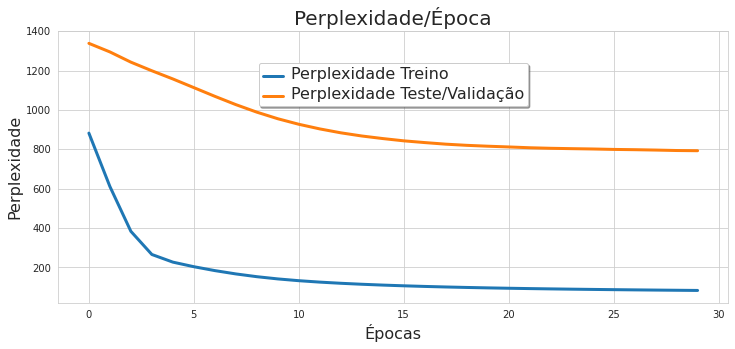

In [21]:
plota_perplexidade(train_perplex_loss_list,valid_perplex_loss_list,N_EPOCHS)

# Testando para o token size total (Treino/Validação)




In [0]:
CONTEXT_SIZE = 5
EMBEDDING_DIM = 50
N_EPOCHS = 30
BATCH_SIZE = 50 
VOCAB_SIZE  = 1000
TRAIN_TOKENS_SIZE,VALID_TOKEN_SIZE = train_tokens_size,valid_tokens_size
LR = 0.0001
PATH_TRAIN,PATH_VALID = 'wikitext-2/wiki.train.tokens','wikitext-2/wiki.valid.tokens'
train_perplex_loss_list,valid_perplex_loss_list = evaluate_model(CONTEXT_SIZE,EMBEDDING_DIM,N_EPOCHS,BATCH_SIZE,VOCAB_SIZE,TRAIN_TOKENS_SIZE,VALID_TOKEN_SIZE,LR,PATH_TRAIN,PATH_VALID,TOKENS_LIMIT=False)



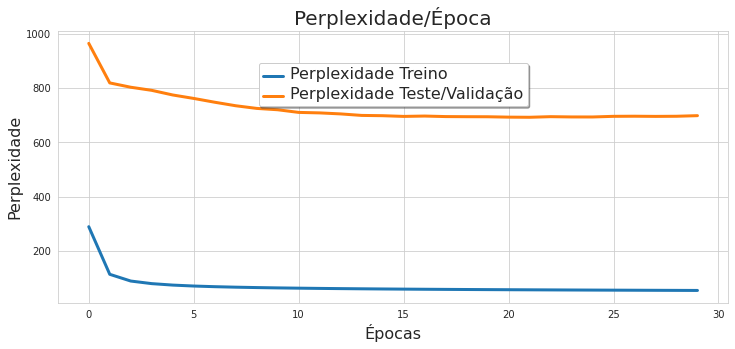

In [23]:
plota_perplexidade(train_perplex_loss_list,valid_perplex_loss_list,N_EPOCHS)

# Testando para o token size total (Treino/Teste)

In [0]:
CONTEXT_SIZE = 5
EMBEDDING_DIM = 50
N_EPOCHS = 30
BATCH_SIZE = 50 
VOCAB_SIZE  = 1000
TRAIN_TOKENS_SIZE,VALID_TOKEN_SIZE = train_tokens_size,test_tokens_size
LR = 0.0001
TOKENS_LIMIT= False
PATH_TRAIN,PATH_VALID = 'wikitext-2/wiki.train.tokens','wikitext-2/wiki.test.tokens'


train_perplex_loss_list,valid_perplex_loss_list = evaluate_model(CONTEXT_SIZE,EMBEDDING_DIM,N_EPOCHS,BATCH_SIZE,VOCAB_SIZE,TRAIN_TOKENS_SIZE,VALID_TOKEN_SIZE,LR,PATH_TRAIN,PATH_VALID,TOKENS_LIMIT=False)



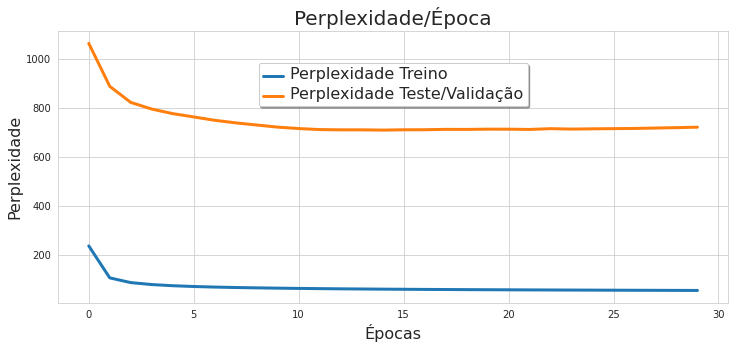

In [25]:
plota_perplexidade(train_perplex_loss_list,valid_perplex_loss_list,N_EPOCHS)